# PROYECTO PREPARACIÓN Y LIMPIEZA DE DATOS

## Health Insurance Cross Sell Prediction

El proyecto a desarrollar consta de datos de clientes que una compañia de seguros ha cedido para realizar un modelo predictivo y decidir si los clientes de la anualidad anterior sería elegibles para ofrecerles una póliza para su coche.

El valor que el proyecto aporta a la compañia está relacionado con optimizar los costes de las campañas de marketing y así reducir los costes y eitar publicidad innecesaria a clientes que haya poca o nula posibilidad que contarten dicho seguro para su coche.

El proyecto consiste en dos datasets, uno para realizar el entrenamiento del modelo y otro para realizar el test y comprobar su rendimiento. 

El dataset ha sido obtenido de Kaggle: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction?resource=download&select=train.csv

---------------------------------------------------------------------------------------------------------------------------------------------------

# Prerrequisitos

### Importar librerías

In [1]:
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow as pa
import numpy as np
from  sklearn import model_selection
import pandas as pd

In [2]:
import numpy as np
import pandas as pd
import warnings
#---librerías gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from matplotlib.colors import ListedColormap
#...generación de datos sintéticos
from sklearn.datasets import make_blobs
#....importamos las librería para estandarizar o normalizar.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#....generación de las muestras de entrenamiento y test
from sklearn.model_selection import train_test_split
#....corrección de asimetría de clases
from imblearn.over_sampling import RandomOverSampler
#....modelo árboles de decisión
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
#....modelo Random Forest
from sklearn.ensemble import RandomForestClassifier
#...optimización del modelo con cross-validation y GridSearch
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#----métricas de clasificación
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
#...curvas ROC y PRC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance #orden de la importancia de las variables basada en permutaciones

In [211]:
# Download latest version
path = kagglehub.dataset_download("anmolkumar/health-insurance-cross-sell-prediction")

print("Path to dataset files:", path)

path_to_train = path + "/train.csv" 
path_to_test = path + "/test.csv"

Path to dataset files: /root/.cache/kagglehub/datasets/anmolkumar/health-insurance-cross-sell-prediction/versions/1


Con este código descargamos el dataset directamente de Kaggle si no se tiene descargado en local. Este método ayuda mucho a una posterior ejecución en otro entorno 

### Cargamos el dataset 

In [3]:
df = pd.read_csv(path_to_train)#Cargamos el df


NameError: name 'path_to_train' is not defined

In [213]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Columnas del dataset 

Ahora, para predecir si el cliente estará interesado en un seguro de vehículo, se dispone de información sobre datos demográficos (sexo, edad, tipo de código regional), vehículos (antigüedad del vehículo, daños), póliza (prima, canal de contratación), etc.

1. id: Identificador unico ID de cada cliente.

2. Gender: Género del asegurado.

3. Age: Edad del asegurado.

4. Driving_License: 0: El asegurado no tiene permiso de conducción, 1: El asegurado tiene permiso de conducción.

5. Region_Code: Código único para la región a la que pertenece el asegurado.

6. Previously_Insured: 0: El cliente no tiene una póliza de seguro para el vehículo con la compañia, 1: El cliente ya tiene contratada una póliza de seguro de vehículo con la compañia.

7. Vehicle_Age: Edad del vehículo.

8. Vehicle_Damage: 0: El vehículo del asegurado no ha tenido daños en el pasado, 1: El vehículo del asegurado ha tenido daños en el pasado.

9. Annual_Premium: La prima de cada cliente

10. Policy_Sales_Channel: Código anónimo para el canal de contacto con el cliente, es decir, diferentes agentes, por correo, por teléfono, en persona, etc.

11. Vintage: Numero de días que el cliente ha estado asociado a la compañia

12. Response: 0: El cliente no está interesado en una póliza para el vehículo, 1: El cliente está interesado en una póliza para el vehículo.

---------------------------------------------------------------------------------------------------------------------------------------------------

# 1 Entendiendo el dataset

### 1.1 - Check the head, shape, data-types of the features

Comprobamos los datatypes de cada columna del dataframe

In [214]:
for column in df.columns:
    print(f"{column} : {df[column].dtype}")

id : int64
Gender : object
Age : int64
Driving_License : int64
Region_Code : float64
Previously_Insured : int64
Vehicle_Age : object
Vehicle_Damage : object
Annual_Premium : float64
Policy_Sales_Channel : float64
Vintage : int64
Response : int64


In [215]:
print(df.shape)

(381109, 12)


Vamos a comprobar los datatypes de cada columna y modificarlos para mejorar el rendiemiento a la hora de entrenar un modelo

In [216]:
for column in df.columns:
    print(f"{column} : {df[column].dtype}")

id : int64
Gender : object
Age : int64
Driving_License : int64
Region_Code : float64
Previously_Insured : int64
Vehicle_Age : object
Vehicle_Damage : object
Annual_Premium : float64
Policy_Sales_Channel : float64
Vintage : int64
Response : int64


### 1.2 Check the statistical values of features


In [217]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


### 1.3 Identifique las columnas que contienen un valor único

Elimine las columnas que contengan un solo valor

In [218]:
columnas_pocos_valores = {}
columnas_muchos_valores = {}

for column in df.columns:
    n_unique = df[column].nunique()  # En Pandas se usa .nunique()
    
    if n_unique < 5:
        columnas_pocos_valores[column] = n_unique
    else:
        columnas_muchos_valores[column] = n_unique

    print(f"{column} : {n_unique}")

# Opcional: Mostrar los resultados de forma clara
print("\nColumnas con pocos valores únicos 'Variables Categóricas'")
print(columnas_pocos_valores)

print("\nColumnas con muchos valores únicos 'Variables Numéricas'")
print(columnas_muchos_valores)


id : 381109
Gender : 2
Age : 66
Driving_License : 2
Region_Code : 53
Previously_Insured : 2
Vehicle_Age : 3
Vehicle_Damage : 2
Annual_Premium : 48838
Policy_Sales_Channel : 155
Vintage : 290
Response : 2

Columnas con pocos valores únicos 'Variables Categóricas'
{'Gender': 2, 'Driving_License': 2, 'Previously_Insured': 2, 'Vehicle_Age': 3, 'Vehicle_Damage': 2, 'Response': 2}

Columnas con muchos valores únicos 'Variables Numéricas'
{'id': 381109, 'Age': 66, 'Region_Code': 53, 'Annual_Premium': 48838, 'Policy_Sales_Channel': 155, 'Vintage': 290}


Como se pede observar no existe ninguna columna con un único valor, las columnas con menos categorías son 2 por lo que no es necesario realizar ninguna operación por ahora.

Podemos observar tambien que las variables con pocos valores son las categoricas mientras que las que tienen muchos valores son las continuas. Vamos a separarlas para estudar la varianza de las variables contínuas.



In [219]:
# Seleccionar columnas categóricas (con pocos valores únicos)
variables_categoricas = df[list(columnas_pocos_valores.keys())]

# Seleccionar columnas numéricas (con muchos valores únicos)
variables_numericas = df[list(columnas_muchos_valores.keys())]


### 1.4 Considere las columnas que tienen muy pocos valores


Las columnas con valores únicos altos corresponden a columnas numéricas mientras que las que tienen valores inicos bajos se refieren a categóricas. Las variables categoricas se pueden transformar en variables booleanas para que el modelo lo interprete con mayor facilidad. No es necesario usar get_dummies puesto que solo tienen 2 categorías.

### 1.5 Quite las columnas que tengan una varianza baja


In [220]:
# Calcular varianza y desviación estándar de cada columna
variances = variables_numericas.var()
std_devs = variables_numericas.std()

# Combinar ambos resultados en un solo DataFrame
variances_df = pd.DataFrame({
    "varianza": variances,
    "desviacion_estandar": std_devs
}).reset_index()

# Renombrar las columnas
variances_df.columns = ["variable", "varianza", "desviacion_estandar"]

# Ordenar por la varianza
variances_df = variances_df.sort_values("varianza")

# Mostrar el DataFrame con varianza y desviación estándar
print(variances_df)



#print("Varianza:\n", variances)
#print("Desviación estándar:\n", std_devs)

               variable      varianza  desviacion_estandar
2           Region_Code  1.750299e+02            13.229888
1                   Age  2.406101e+02            15.511611
4  Policy_Sales_Channel  2.938073e+03            54.203995
5               Vintage  7.000887e+03            83.671304
3        Annual_Premium  2.962927e+08         17213.155057
0                    id  1.210370e+10        110016.836208


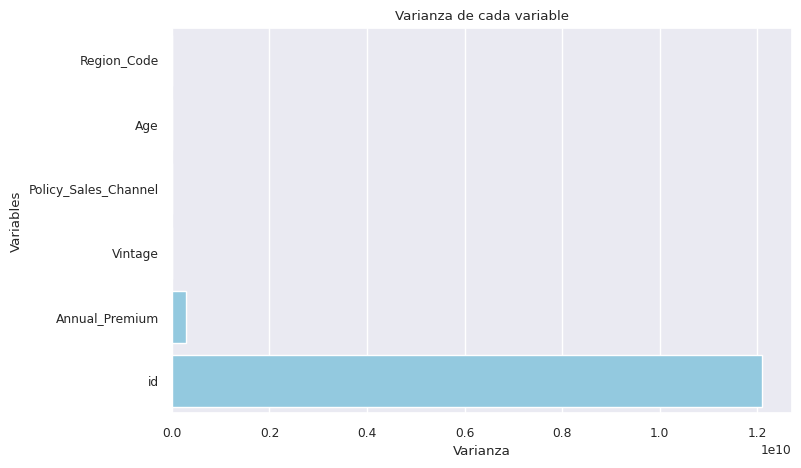

In [221]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(8, 5))
sns.barplot(x="varianza", y="variable", data=variances_df, orient="h", color='skyblue')
plt.title("Varianza de cada variable")
plt.xlabel("Varianza")
plt.ylabel("Variables")
plt.show()

Como podemos ver la escala de los valores es muy dispersa. Vamos a coregir esto y estandarizar las metricas para poder compararlas. Pare ello utilizareos el coeficiente de variación

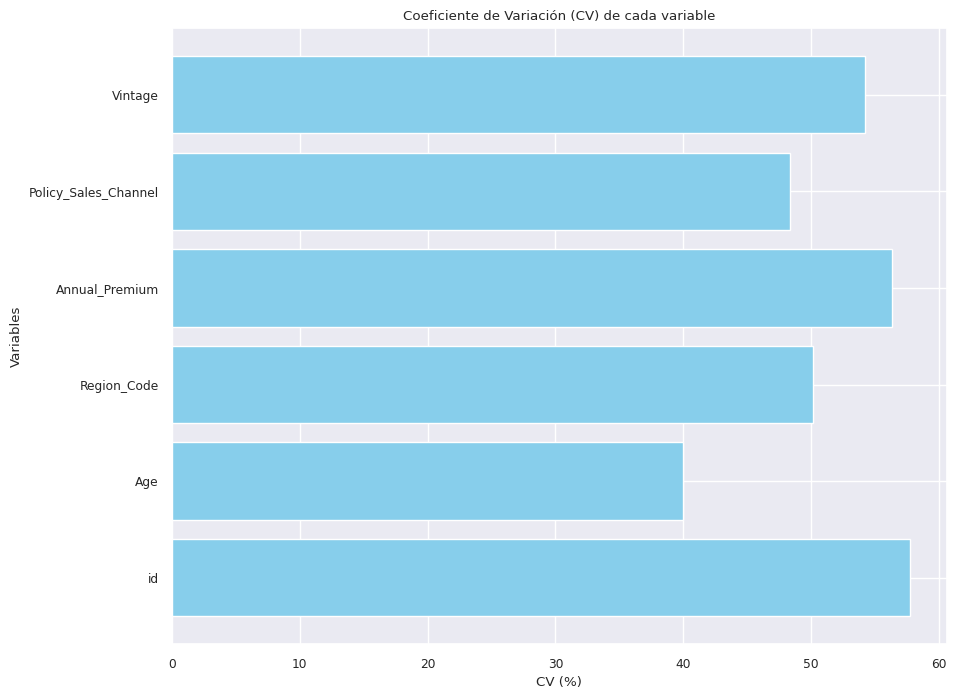

In [222]:
# Suponiendo que 'variables_numericas' es un DataFrame de Pandas
# Calcular el coeficiente de variación (CV) para cada columna
cv_df = variables_numericas.apply(lambda col: col.std() / col.mean() * 100)

# Transponer el DataFrame para la visualización
cv_df = cv_df.reset_index()
cv_df.columns = ['variable', 'cv']

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
plt.barh(cv_df['variable'], cv_df['cv'], color='skyblue')
plt.title("Coeficiente de Variación (CV) de cada variable")
plt.xlabel("CV (%)")
plt.ylabel("Variables")
plt.show()

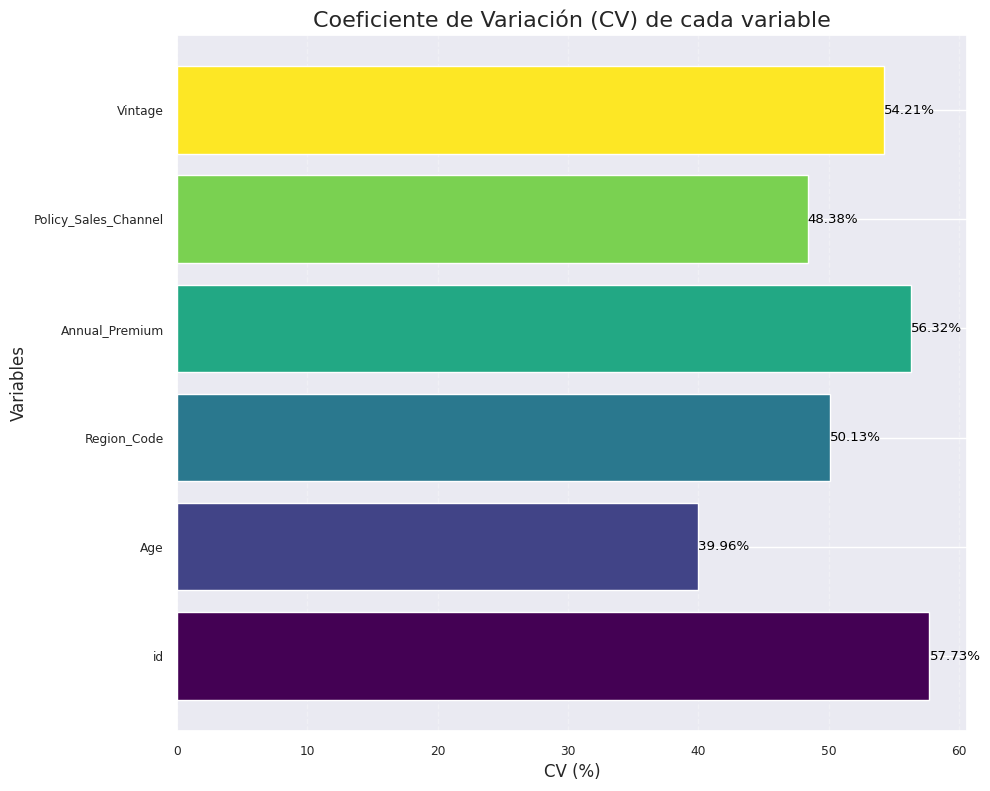

In [223]:
# Suponiendo que 'variables_numericas' es un DataFrame de Pandas
# Calcular el coeficiente de variación (CV) para cada columna
cv_df = variables_numericas.apply(lambda col: col.std() / col.mean() * 100)

# Transponer el DataFrame para la visualización
cv_df = cv_df.reset_index()
cv_df.columns = ['variable', 'cv']

# Extraer los datos de Pandas como listas
variables = cv_df['variable'].tolist()
cvs = cv_df['cv'].tolist()

# Crear el gráfico de barras horizontales con Matplotlib
plt.figure(figsize=(10, 8))
bars = plt.barh(variables, cvs, color=plt.cm.viridis(np.linspace(0, 1, len(variables))))

# Añadir etiquetas de valor en las barras
for bar in bars:
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2,  # Posición de la etiqueta
        f'{bar.get_width():.2f}%', # Texto de la etiqueta
        va='center', ha='left', # Alineación vertical y horizontal
        color='black'
    )

plt.title("Coeficiente de Variación (CV) de cada variable", fontsize=16)
plt.xlabel("CV (%)", fontsize=12)
plt.ylabel("Variables", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Como se pude observar todas las variables numéricas tienen un coeficiente de variación en torno al 50 por ciento lo que no indica ni variabilidad muy alta ni muy baja

### 1.6 - Identifique las filas que contienen datos duplicados


In [224]:
df_duplicates = df[df.duplicated()]

print(df_duplicates)

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []


Podemos observar que no existe ninguna fila duplicada, solo coinciden en que tienen el mismo valor para la variable 'Annual_Premium'

### 1.7 - check the missing values


In [225]:
print(columnas_muchos_valores.keys())

dict_keys(['id', 'Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'])


In [226]:
for col in df.columns:
    print(f"La columna '{col}' contiene: {df[col].isnull().sum()} valores nulos")

La columna 'id' contiene: 0 valores nulos
La columna 'Gender' contiene: 0 valores nulos
La columna 'Age' contiene: 0 valores nulos
La columna 'Driving_License' contiene: 0 valores nulos
La columna 'Region_Code' contiene: 0 valores nulos
La columna 'Previously_Insured' contiene: 0 valores nulos
La columna 'Vehicle_Age' contiene: 0 valores nulos
La columna 'Vehicle_Damage' contiene: 0 valores nulos
La columna 'Annual_Premium' contiene: 0 valores nulos
La columna 'Policy_Sales_Channel' contiene: 0 valores nulos
La columna 'Vintage' contiene: 0 valores nulos
La columna 'Response' contiene: 0 valores nulos


Podemos observar que no existen valores nulos en el dataset

### 1.8 Detect strange values apart from the NaN Values

Vamos a checkear los outliers

In [227]:
# Función para detectar outliers usando el rango intercuartílico (IQR)
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (df[col] < lower_bound) | (df[col] > upper_bound)  # Devuelve una serie booleana

# Aplicar la función de detección de outliers a cada columna numérica
outliers_df = pd.DataFrame({col: detect_outliers(df, col) for col in variables_numericas})

# Contar el número de outliers por columna
outliers_count = outliers_df.sum()

# Contar el total de outliers en el dataset
total_outliers = outliers_df.any(axis=1).sum()

# Calcular el porcentaje de outliers respecto al total de filas
total_rows = len(df)
outlier_percentage = (total_outliers / total_rows) * 100

# Filtrar las filas que tienen al menos un outlier
df_outliers_filtered = df[outliers_df.any(axis=1)]

# Mostrar resultados
print("Número de outliers por columna:")
print(outliers_count)
print(f"\nTotal de filas con al menos un outlier: {total_outliers} de {total_rows} ({outlier_percentage:.2f}%)")
print("\nDataFrame con filas que contienen outliers:")
df_outliers_filtered

Número de outliers por columna:
id                          0
Age                         0
Region_Code                 0
Annual_Premium          10320
Policy_Sales_Channel        0
Vintage                     0
dtype: int64

Total de filas con al menos un outlier: 10320 de 381109 (2.71%)

DataFrame con filas que contienen outliers:


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
25,26,Female,21,1,28.0,1,< 1 Year,No,61964.0,152.0,72,0
37,38,Female,25,1,28.0,1,< 1 Year,No,76251.0,152.0,107,0
67,68,Male,60,1,28.0,0,1-2 Year,Yes,66338.0,124.0,73,0
139,140,Male,21,1,29.0,1,< 1 Year,No,62164.0,152.0,116,0
149,150,Female,22,1,11.0,1,< 1 Year,No,76651.0,152.0,258,0
...,...,...,...,...,...,...,...,...,...,...,...,...
380959,380960,Male,25,1,8.0,1,< 1 Year,No,61909.0,152.0,161,0
380998,380999,Female,33,1,8.0,0,1-2 Year,Yes,101664.0,124.0,21,0
381035,381036,Female,22,1,11.0,1,< 1 Year,No,62889.0,152.0,295,0
381047,381048,Female,52,1,8.0,1,1-2 Year,No,71915.0,7.0,233,0


Comprobamos que solo aparecen "Outliers" en a variable Annual_premium", por lo que vamos a indagar mas en esta variable para ver como se comporta y si realmente son outliers

Vamos a graficar los violincharts de las columnas numéricas, es decir las no categóricas

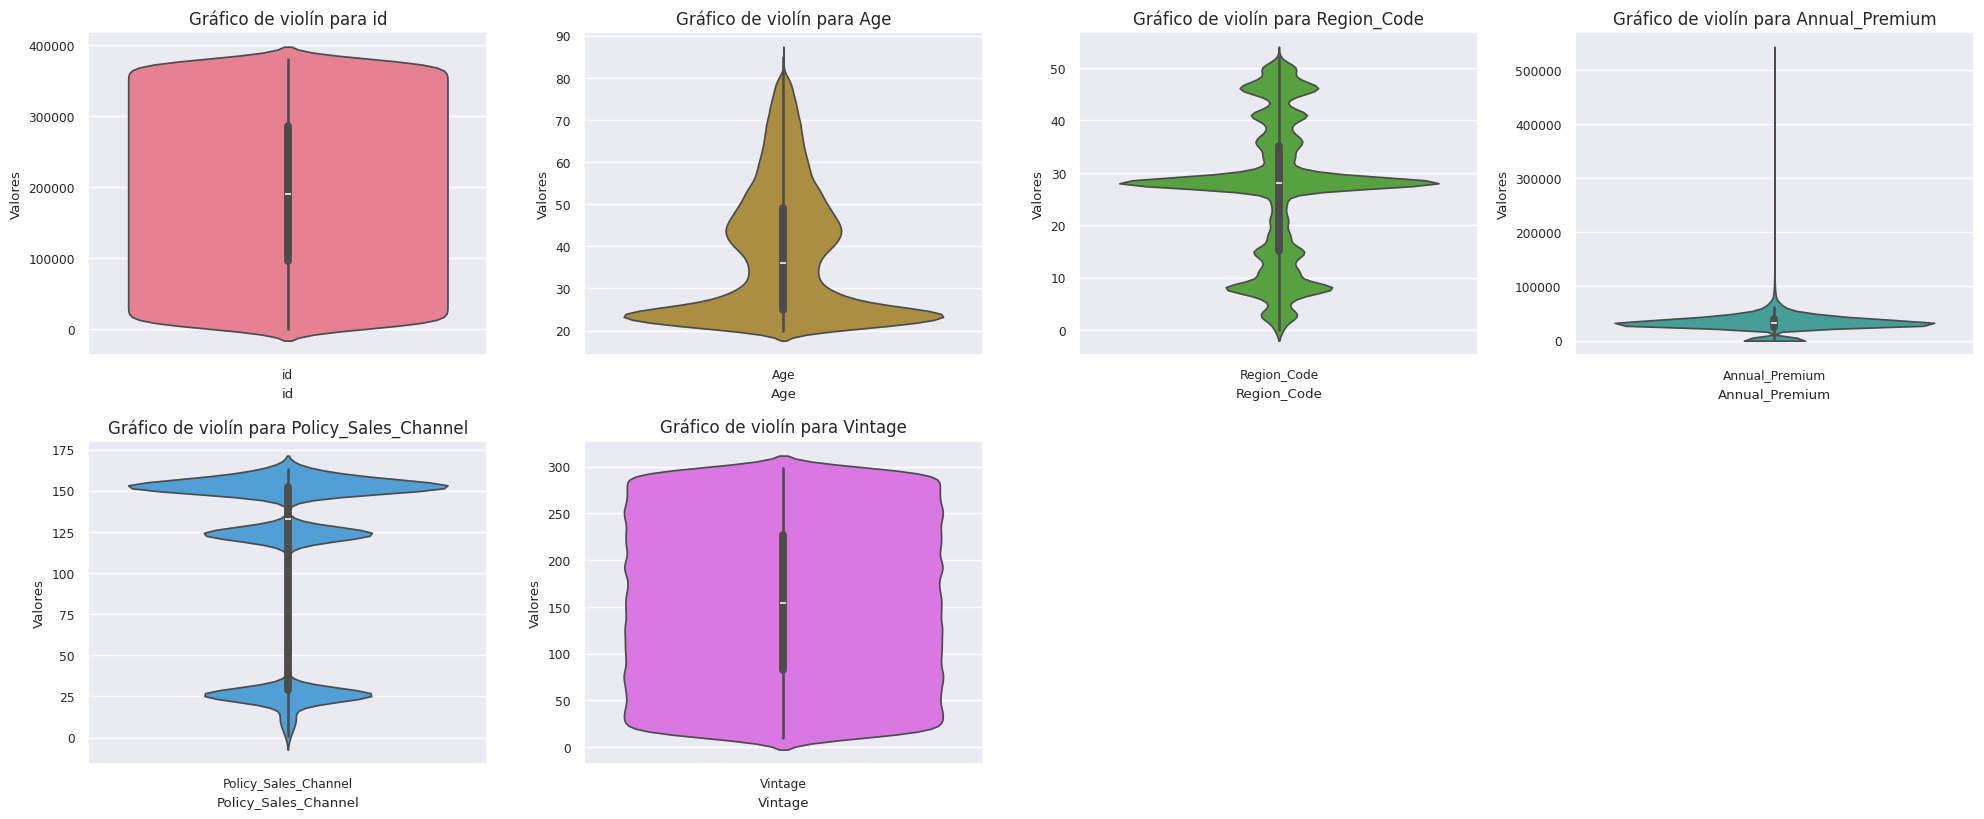

In [228]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

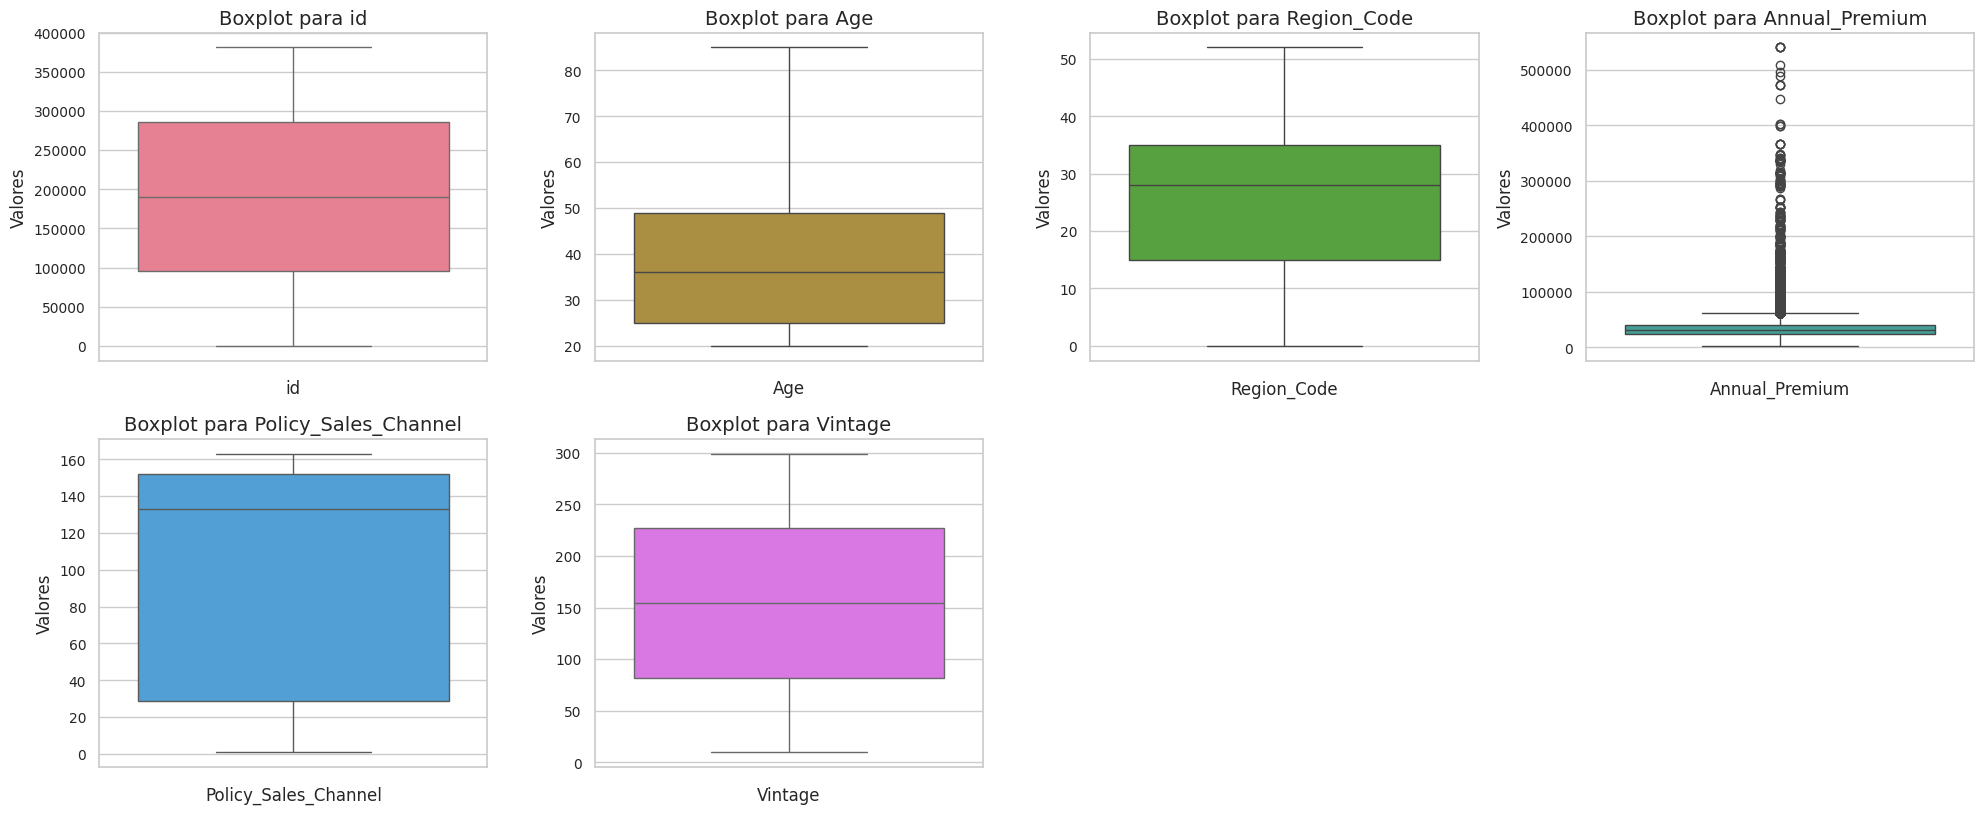

In [229]:
num_cols = len(df.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

# Posible problema !!

Si analizamos la columna Annual_Premium que analiza la poliza de cada cliente podemos ver que la mayoria de los datos se acumulan en una distribucion normal en valores por debajo de 100k. Sin embargo vemos tambien que hay una larga cola hacia la derecha lo que puede indicar un subproblema para rentas mas altas. vamos a segmentar el dataset y analizar los outliers a ver como se distribuyen, su numero y si merece ahcer un modelado aparte para estos datos.

La columna id la podemos obviar puesto que es una columna de identificadores únicos

Vamos a establecer una separación en el dataset para clientes que pagan una prima superior e inferior, separándolos en dos categorias

In [230]:
# Calcular los cuartiles y el rango intercuartílico (IQR)
q1 = df['Annual_Premium'].quantile(0.15)
q3 = df['Annual_Premium'].quantile(0.85)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR


In [231]:
# Filtrar los valores dentro del rango (menor o igual que upper_bound)
df_filtrado = df[df['Annual_Premium'] <= upper_bound]

# Filtrar los valores fuera del rango (mayor o igual que upper_bound)
df_filtrado_premium = df[df['Annual_Premium'] >= upper_bound]

Volvemos a comprobar distribuciones de df_filtrado, con los clientes con una prima inferior a 107k y clientes premium con primas superiores a esto.

#### Dataframe con clientes premium Violinchart y Boxplot

In [232]:
df_filtrado_premium.shape

(546, 12)

In [233]:
min_annual_premium = df_filtrado_premium['Annual_Premium'].min()
print(min_annual_premium)

107446.0


Vemos que el df ha establecido que el corte de la distribucón por prima se stablezca en 107k.

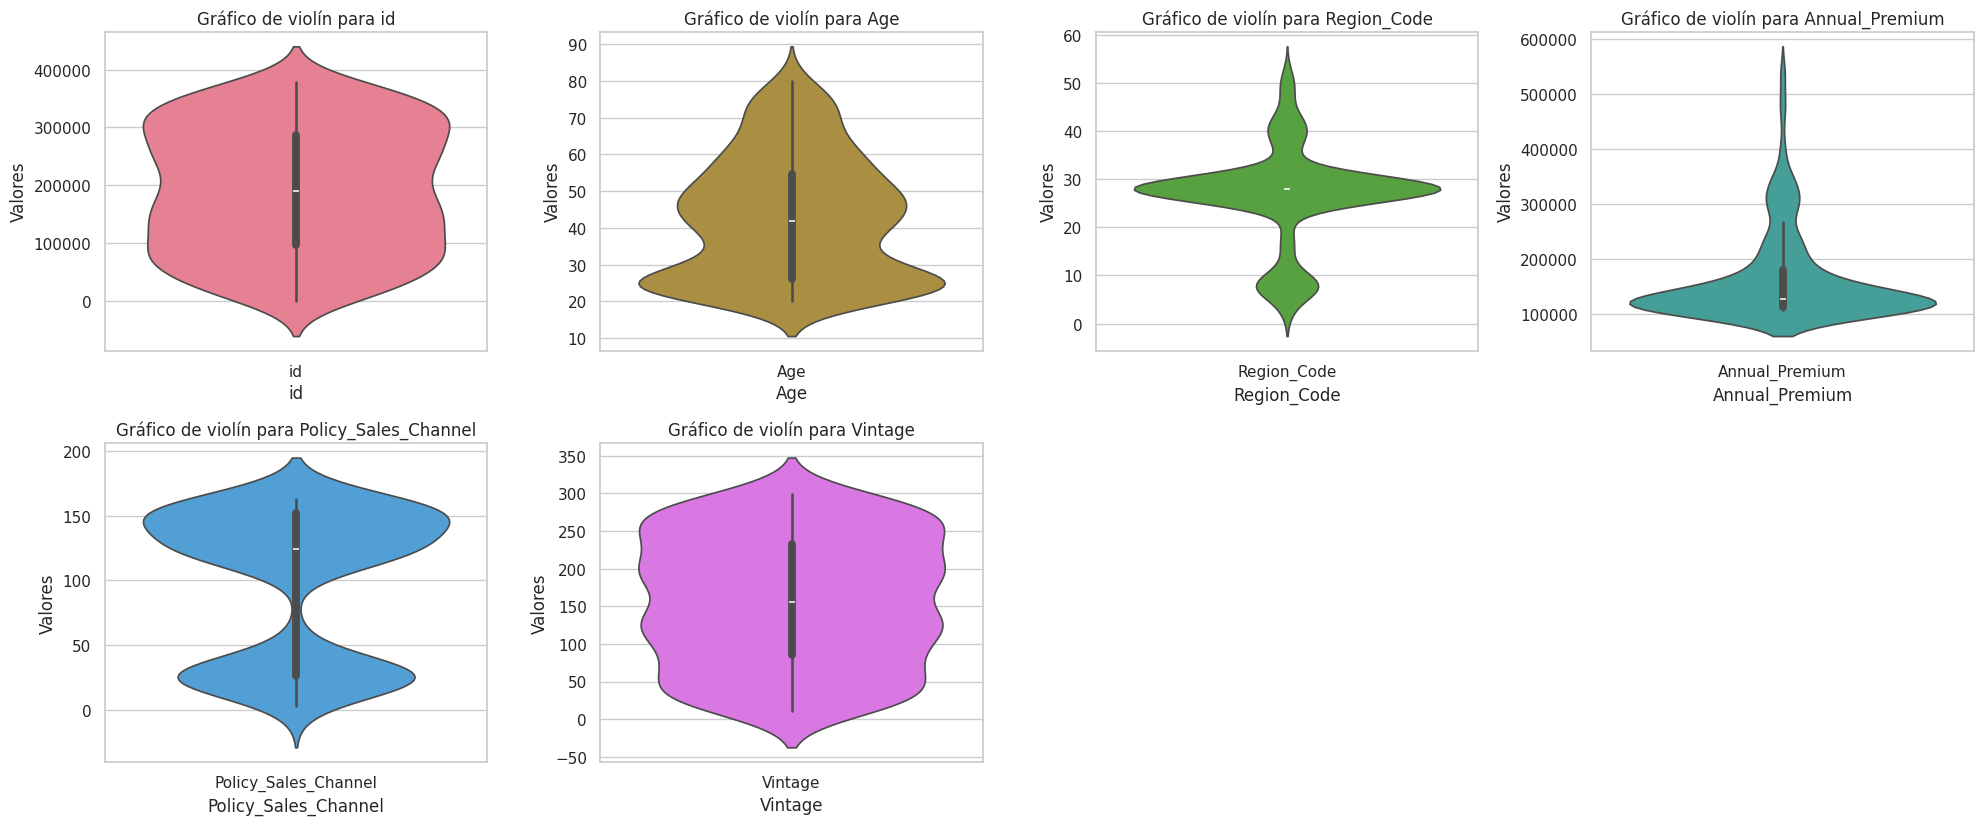

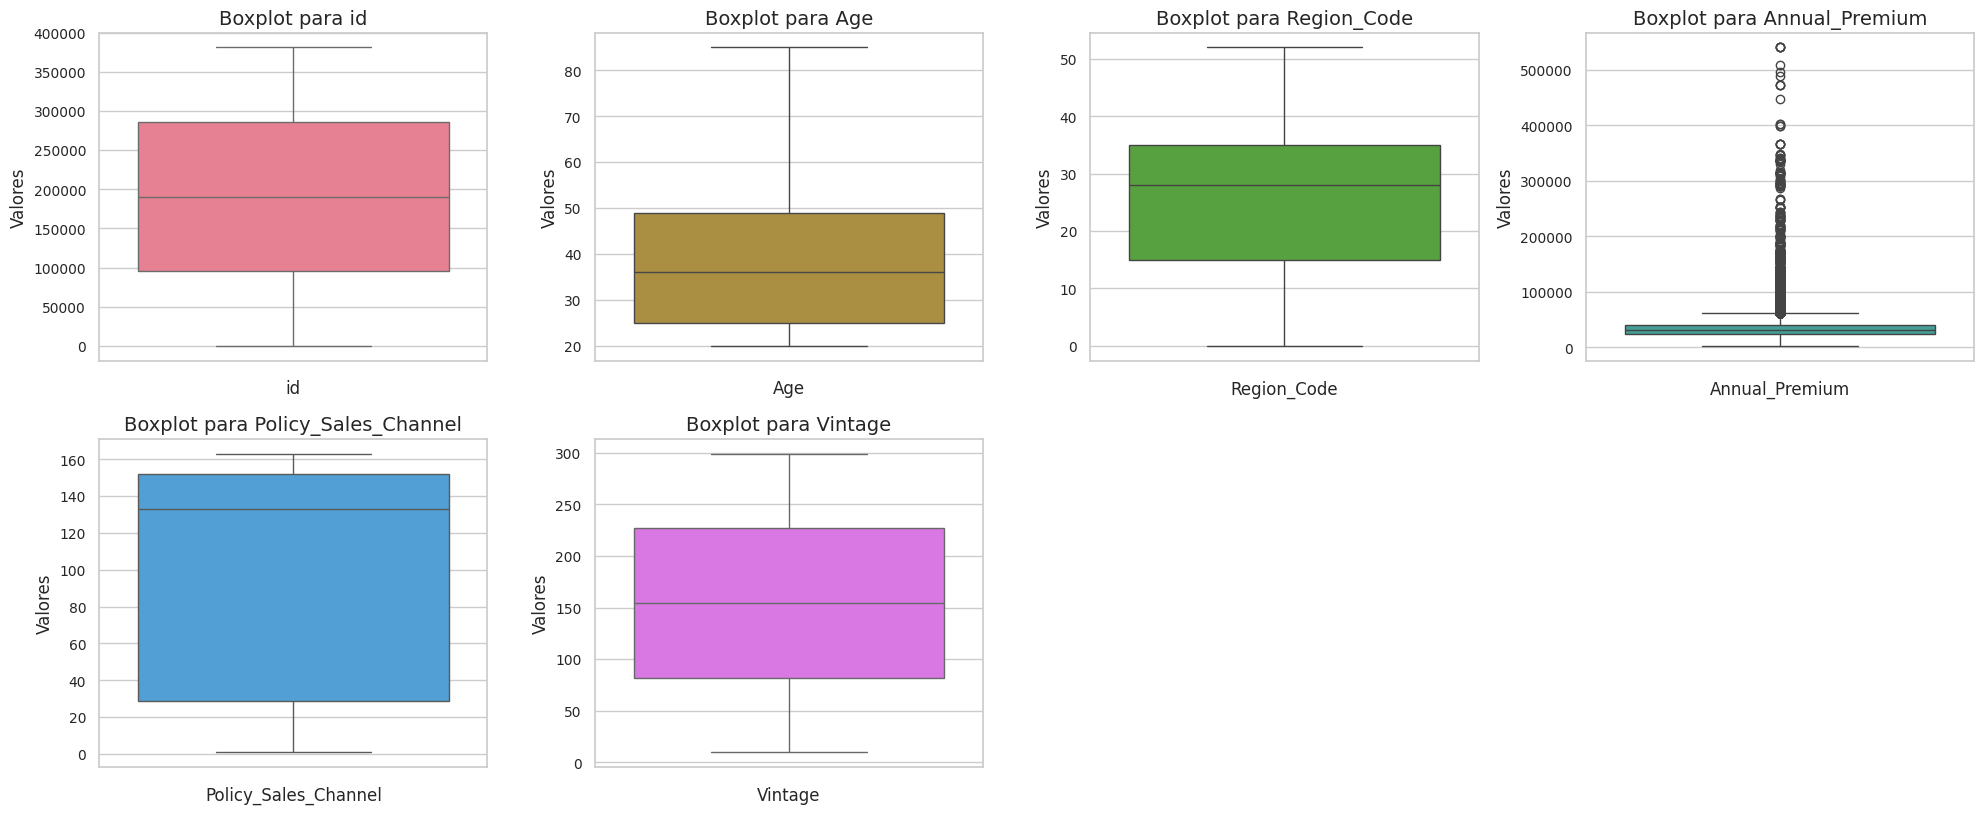

In [234]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df_filtrado_premium.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df_filtrado_premium[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

# Boxplot

num_cols = len(df_filtrado_premium.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

#### Dataframe con clientes estandar Violinchart y Boxplot

In [235]:
df_filtrado.shape

(380563, 12)

In [236]:
max_annual_premium = df_filtrado['Annual_Premium'].max()
print(max_annual_premium)

107292.0


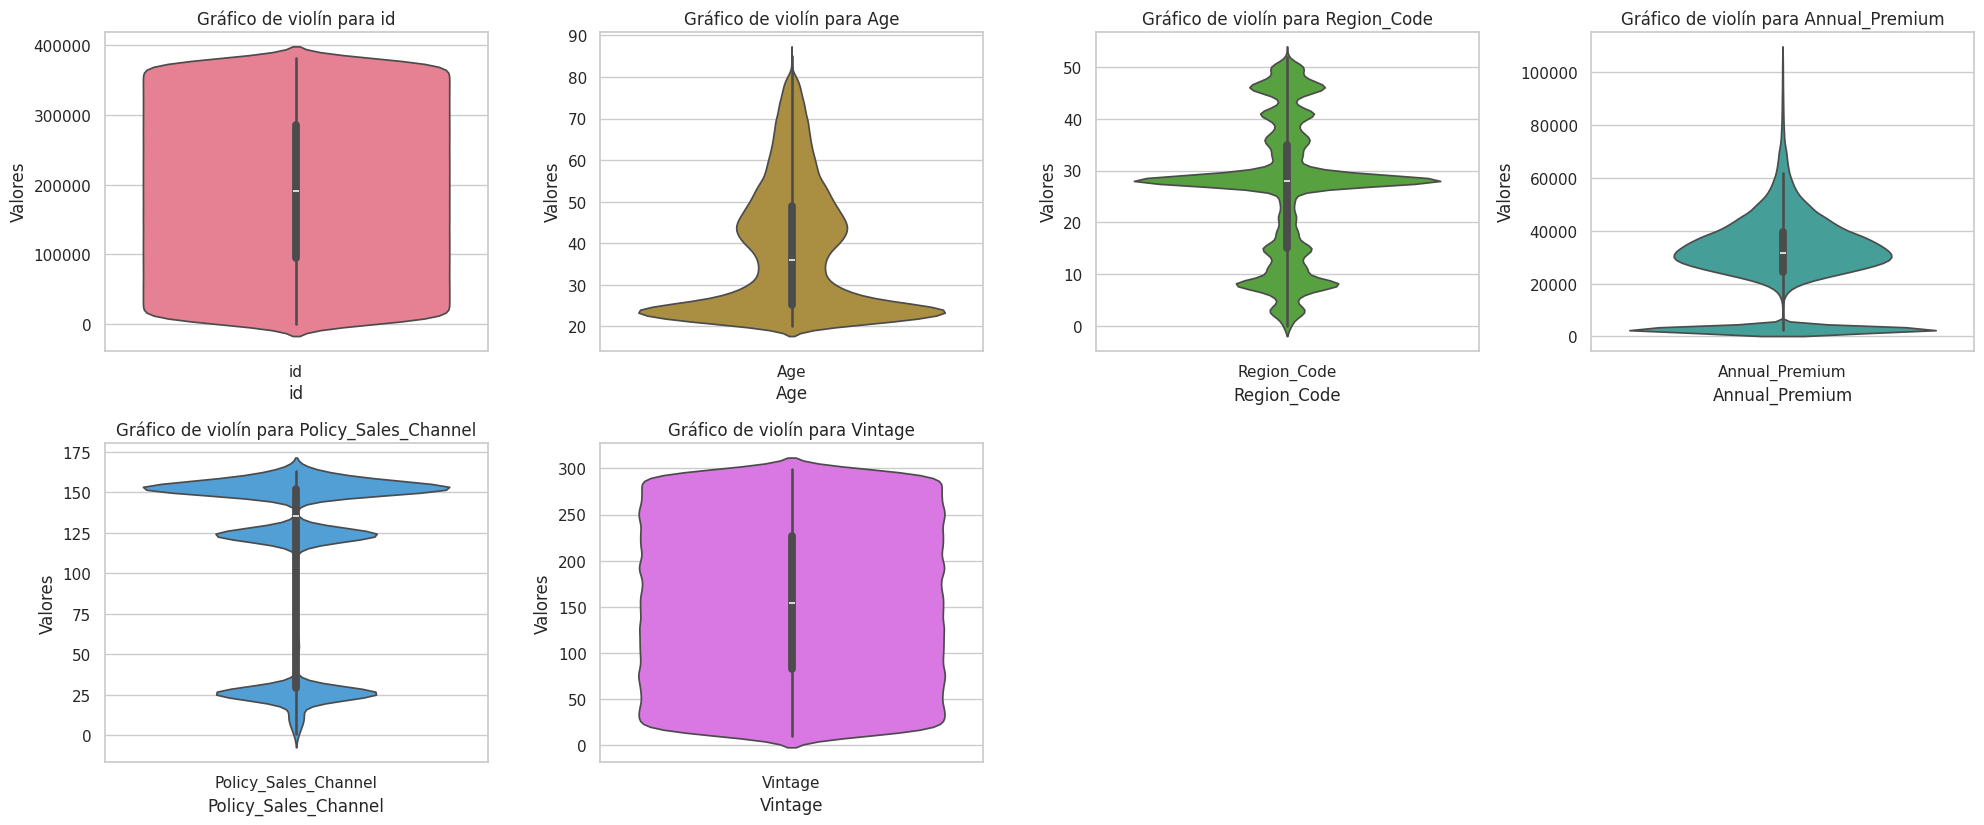

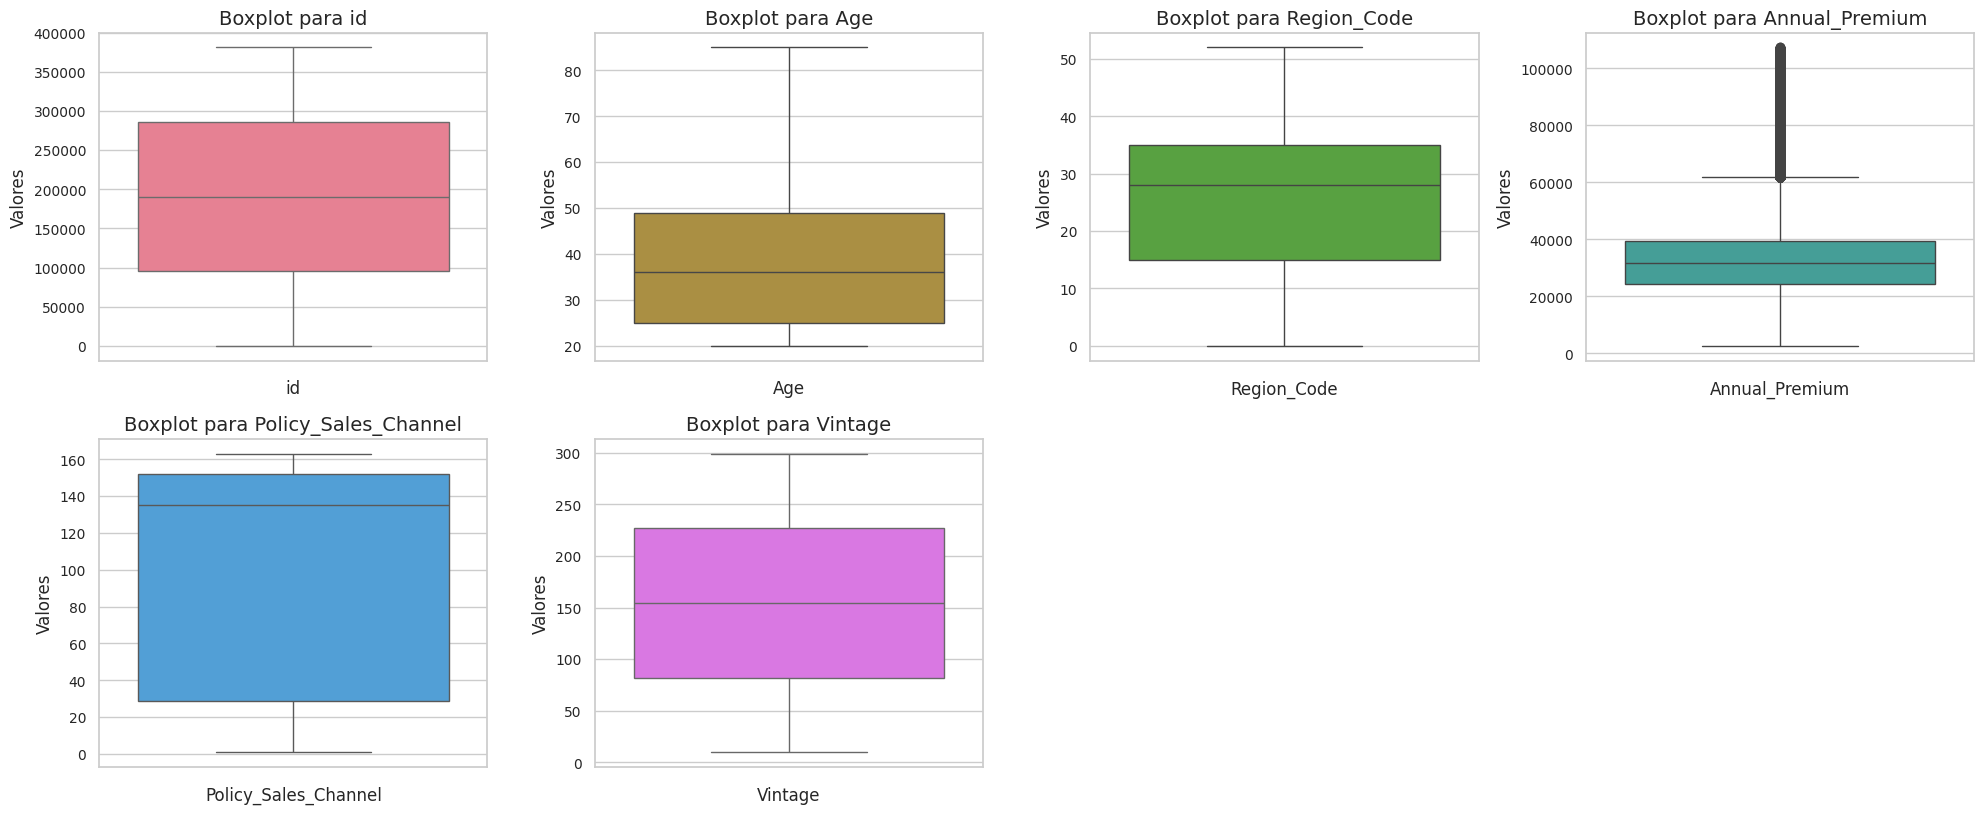

In [237]:
# Crear una cuadrícula de gráficos de violín con 4 gráficos por línea
num_cols = len(df_filtrado.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(columnas_muchos_valores))


for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.violinplot(ax=axes[row, col], data=df_filtrado[[column]], color=palette[i])
    axes[row, col].set_title(f'Gráfico de violín para {column}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Valores')

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

num_cols = len(df_filtrado.columns)
num_plots_per_row = 4
num_rows = (num_cols + num_plots_per_row - 1) // num_plots_per_row

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(20, 4 * num_rows))

sns.set(style="whitegrid")

palette = sns.color_palette("husl", len(columnas_muchos_valores))
                            
for i, column in enumerate(columnas_muchos_valores.keys()):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(ax=axes[row, col], data=df_filtrado[column],color=palette[i])
    axes[row, col].set_title(f'Boxplot para {column}', fontsize=14)
    axes[row, col].set_xlabel(column, fontsize=12)
    axes[row, col].set_ylabel('Valores', fontsize=12)
    axes[row, col].tick_params(axis='both', which='major', labelsize=10)

# Eliminar ejes vacíos
for j in range(i + 1, num_rows * num_plots_per_row):
    fig.delaxes(axes[j // num_plots_per_row, j % num_plots_per_row])

plt.tight_layout()
plt.show()

Como podemos ver, la cola de Anual_Premium ha disminuido considerablemente. A partir de ahora continuaremos con df_filtrado 

In [238]:
df = df_filtrado

Definimos los quartiles enfuncion a Annual_Premium y el rango interciartilico para poder filtrar el Dataset

## REPORT

Vamos a utilizar el report de la libreria Sweetviz para sacar más conclusiones de nuestro dataset df_train

M

Me da error y no se por que por eso la comento

In [239]:
#import sweetviz as sv
#st_report = sv.analyze(df)
#st_report.show_notebook()

### 1.9 - Drop the attributes that provide no useful information


In [240]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Vamos a eliminar la variable id ya que como hemos visto, solo es un identificador y no aporta nada. También lo borramos del dataframe de test

In [241]:
df = df.drop(columns=['id'])


Vamos a estudiar correlación entre las variables con la matriz de correlación

In [242]:
df_corr = df.copy()

# Convertir las columnas binarias a 0 y 1
df_corr["Driving_License"] = df_corr["Driving_License"].astype(int)
df_corr["Previously_Insured"] = df_corr["Previously_Insured"].astype(int)
df_corr["Response"] = df_corr["Response"].astype(int)
df_corr["Gender"] = df_corr["Gender"].map({"Male": 1, "Female": 0})  # Asignar 1 a "Male" y 0 a "Female"
df_corr["Vehicle_Damage"] = df_corr["Vehicle_Damage"].map({"Yes": 1, "No": 0})  # Asignar 1 a "Yes" y 0 a "No"

# Convertir "Vehicle_Age" a valores ordinales
df_corr["Vehicle_Age"] = df_corr["Vehicle_Age"].map({
    "< 1 Year": 0,  # Más nuevo
    "1-2 Year": 1,
    "> 2 Years": 2   # Más viejo
})

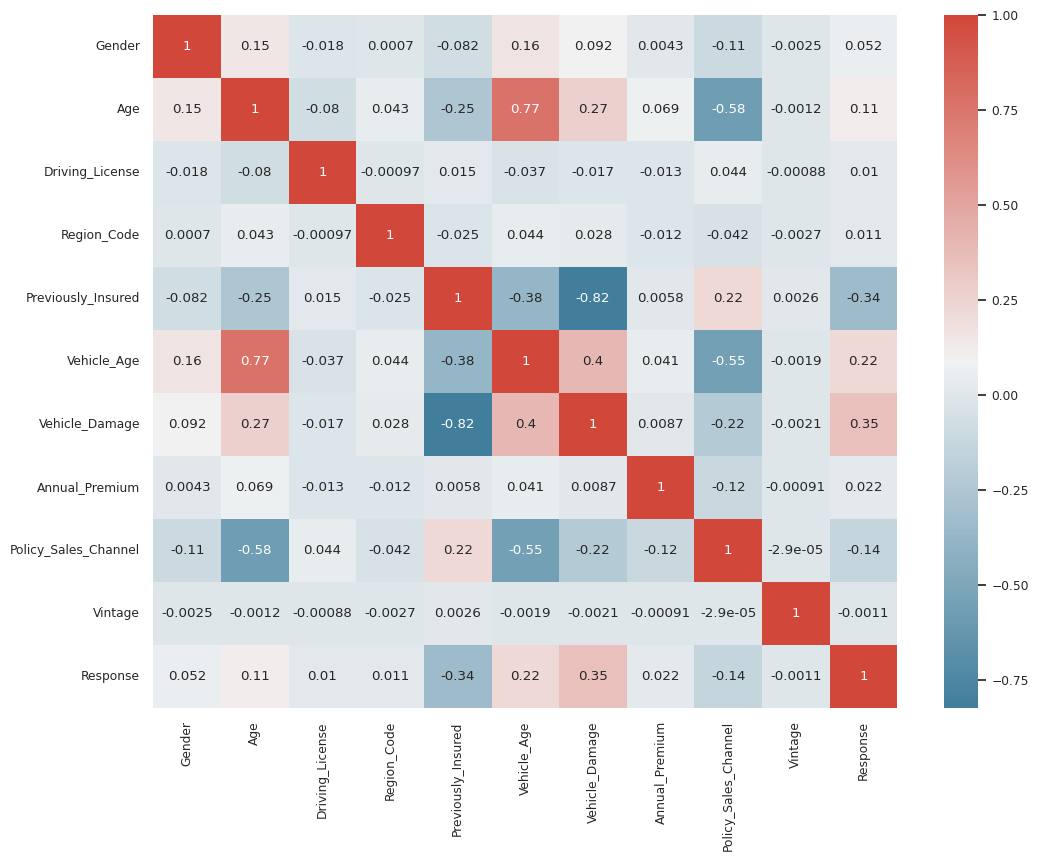

In [243]:
# Eliminar la columna 'Response' y asignar el resultado a 'predictors'
predictors = df_corr

corr = predictors.corr(method='pearson')

plt.figure(figsize=(12,9)) #seleccionamos un tamaño de imagen mayor
sns.set(font_scale=0.8) #seleccionamos un tamaño de letra legible
# preparación del gráfico definiendo un mapa de colores
cmap = sns.diverging_palette(230, 15, as_cmap=True)
# graficamos la correlación
sns.heatmap(corr, annot=True,  cmap=cmap)
plt.show()

# Selección de variables

Puntajes F de regresión para cada característica:
Característica 0: 1046.727042
Característica 1: 4759.192363
Característica 2: 39.018597
Característica 3: 42.026217
Característica 4: 50102.782628
Característica 5: 19688.156439
Característica 6: 54634.762500
Característica 7: 185.481256
Característica 8: 7479.716652
Característica 9: 0.456946


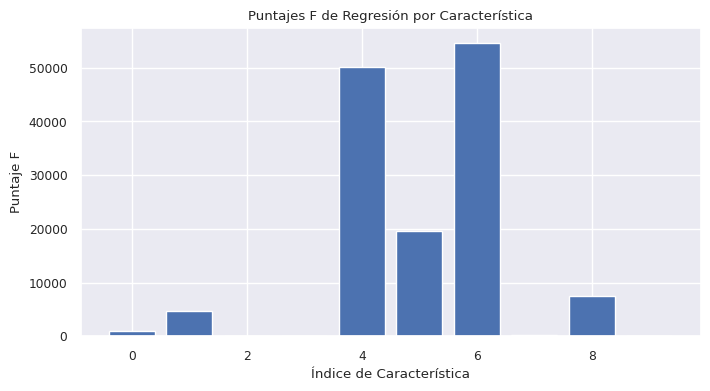

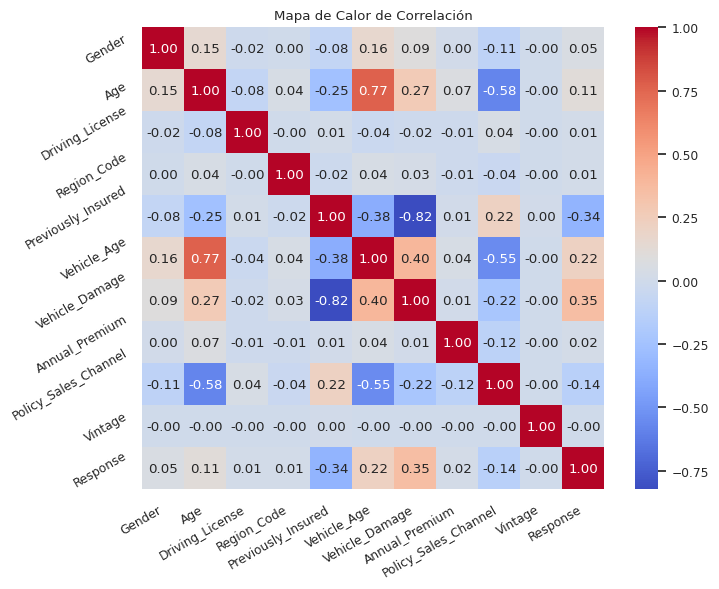

In [244]:
# Selección de características y análisis de correlación en un conjunto de datos numéricos

from sklearn.feature_selection import SelectKBest, f_regression
from matplotlib import pyplot as plt
import seaborn as sns
import random
import numpy as np

# Fijar la semilla para reproducibilidad
np.random.seed(10)
random.seed(10)

# Convertimos el DataFrame de Spark a Pandas
data = df_corr

# Convertimos los datos en un array de NumPy
data = data.values

# Separación de las características (X) y la variable objetivo (y)
X = data[:, :-1]  # Todas las columnas excepto la última
y = data[:, -1]   # Última columna como variable objetivo

# Selección de características usando f_regression (ANOVA para regresión)
# Calcula la relación entre cada característica numérica y la variable objetivo numérica
fs = SelectKBest(score_func=f_regression, k='all')  # 'k' define cuántas características conservar (aquí, todas)
fs.fit(X, y)

# Transformamos X manteniendo las características relevantes (opcional en este caso, ya que evaluamos todas)
X_fs = fs.transform(X)

# Mostramos los puntajes F para cada característica
print("Puntajes F de regresión para cada característica:")
for i in range(len(fs.scores_)):
    print(f'Característica {i}: {fs.scores_[i]:.6f}')

# Gráfica de los puntajes F para cada característica
plt.figure(figsize=(8, 4))
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title("Puntajes F de Regresión por Característica")
plt.xlabel("Índice de Característica")
plt.ylabel("Puntaje F")
plt.show()

# Cálculo de la matriz de correlación
corr_matrix = df_corr.corr()

# Generación de un mapa de calor para visualizar la correlación
plt.figure(figsize=(8, 6))
plt.title("Mapa de Calor de Correlación")
heatmap = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black', cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=30)
plt.show()

In [245]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from numpy import mean, std
import numpy as np
import random

# Fijar la semilla para reproducibilidad
np.random.seed(10)
random.seed(10)

# Definir X (variables independientes) e y (variable objetivo)
X = df_corr.drop(columns=['Response'])  # Reemplaza 'target' con el nombre de tu variable objetivo
y = df_corr['Response']  # Reemplaza 'target' con el nombre de tu variable objetivo

# Configurar RFECV para la selección automática de características
rfecv = RFECV(
    estimator=DecisionTreeRegressor(),
    step=1,
    cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1),
    scoring='neg_mean_absolute_error',
    min_features_to_select=1
)

# Ajustar RFECV al conjunto de datos para seleccionar automáticamente el número óptimo de características
rfecv.fit(X, y)

# Resumen de las características seleccionadas
print("\nSelección de características con RFECV:")
for i, col in enumerate(X.columns):
    print(f'Columna: {col}, Seleccionada={rfecv.support_[i]}, Ranking: {rfecv.ranking_[i]}')

print(f"\nNúmero óptimo de características seleccionadas: {rfecv.n_features_}")



KeyboardInterrupt: 


Importancia de las características:
Característica: 0, Puntuación: 0.02640
Característica: 1, Puntuación: 0.12626
Característica: 2, Puntuación: 0.00046
Característica: 3, Puntuación: 0.10234
Característica: 4, Puntuación: 0.01206
Característica: 5, Puntuación: 0.01047
Característica: 6, Puntuación: 0.12562
Característica: 7, Puntuación: 0.27898
Característica: 8, Puntuación: 0.04376
Característica: 9, Puntuación: 0.27365


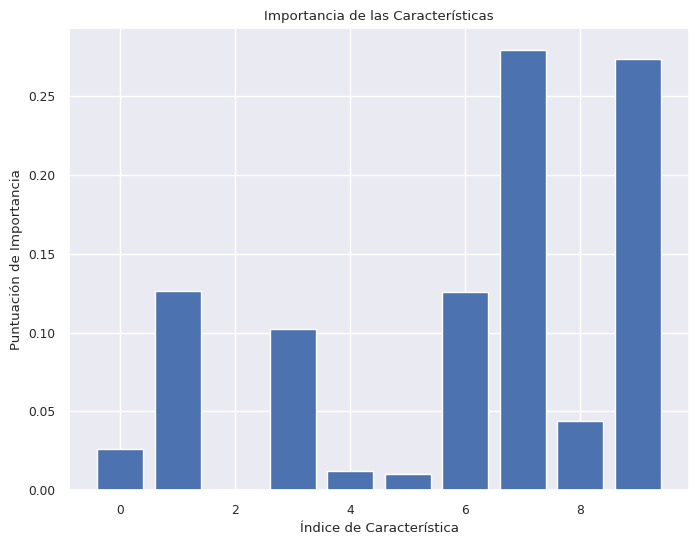

In [ ]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression  # Modelos lineales como Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor  # Basado en árboles
from sklearn.ensemble import RandomForestRegressor  # Modelo de bosque aleatorio para regresión
from matplotlib import pyplot as plt
import numpy as np
import random

# Fijar la semilla para reproducibilidad
np.random.seed(10)
random.seed(10)

# Definir X (variables independientes) e y (variable objetivo)
X = df_corr.drop(columns=['Response'])  # Reemplaza 'target' con el nombre de tu variable objetivo
y = df_corr['Response']  # Reemplaza 'target' con el nombre de tu variable objetivo

# Seleccionar el modelo
# Puedes elegir entre LinearRegression, Ridge, Lasso, ElasticNet o modelos basados en árboles
# model = LinearRegression()  # Modelos lineales
# model = RandomForestRegressor(n_estimators=100, random_state=0)  # Basado en bosques aleatorios
model = DecisionTreeRegressor(random_state=0)  # Modelo basado en árboles

# Ajustar el modelo
model.fit(X, y)

# Obtener la importancia de las características
if hasattr(model, 'coef_'):
    # Para modelos lineales
    importance = model.coef_
elif hasattr(model, 'feature_importances_'):
    # Para modelos basados en árboles
    importance = model.feature_importances_
else:
    raise ValueError("El modelo no tiene soporte para importancia de características.")

# Resumir la importancia de las características
print("\nImportancia de las características:")
for i, v in enumerate(importance):
    print(f'Característica: {i}, Puntuación: {v:.5f}')

# Visualizar la importancia de las características
plt.figure(figsize=(8, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.title("Importancia de las Características")
plt.xlabel("Índice de Característica")
plt.ylabel("Puntuación de Importancia")
plt.show()

### 1.10 Plot distributions

Already did on 1.8

---------------------------------------------------------------------------------------------------------------------------------------------------

# 2 Modeling & Evaluation

### 2.1 - Split-out validation dataset


### Vamos a trabajar con el dataframe df_m1 que será el primer modelo que vamos a analizar, siendo este si hacer feature engineering

In [253]:
# Copiar el DataFrame original
df_m1 = df.copy()
df_m1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [254]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [255]:

df_m1["Driving_License"] = df["Driving_License"].astype(bool)
df_m1["Previously_Insured"] = df["Previously_Insured"].astype(bool)
df_m1["Response"] = df["Response"].astype(bool)
df_m1.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,True,28.0,False,> 2 Years,Yes,40454.0,26.0,217,True
1,Male,76,True,3.0,False,1-2 Year,No,33536.0,26.0,183,False
2,Male,47,True,28.0,False,> 2 Years,Yes,38294.0,26.0,27,True
3,Male,21,True,11.0,True,< 1 Year,No,28619.0,152.0,203,False
4,Female,29,True,41.0,True,< 1 Year,No,27496.0,152.0,39,False


In [256]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

encoder = OneHotEncoder(drop='first')
LabelEncoder = LabelEncoder()

age = LabelEncoder.fit_transform(df_m1['Vehicle_Age'])
gender = encoder.fit_transform(df_m1[["Gender"]])

In [257]:
df_m1 = df_m1.drop(columns=["Vehicle_Age", "Gender"])
df_m1["Age"] = age
df_m1["Gender"] = gender.toarray()

Reorganizamos el dataset para dejar la variable objetivo al final

In [258]:
# Mover la columna 'Response' al final
df_m1 = df_m1[[col for col in df_m1.columns if col != 'Response'] + ['Response']]
df_m1.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Response
0,2,True,28.0,False,Yes,40454.0,26.0,217,1.0,True
1,0,True,3.0,False,No,33536.0,26.0,183,1.0,False
2,2,True,28.0,False,Yes,38294.0,26.0,27,1.0,True
3,1,True,11.0,True,No,28619.0,152.0,203,1.0,False
4,1,True,41.0,True,No,27496.0,152.0,39,0.0,False


### 2.2 - Feature Selection